In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Embedding, TimeDistributed, Lambda, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

## Генерация

In [1]:
loaded_piano_rolls = np.load('input-data/piano_rolls/classical/piano_rolls.npy', allow_pickle=True)

NameError: name 'np' is not defined

In [23]:
sequence_length = int(loaded_piano_rolls[0].shape[0])
num_features = int(loaded_piano_rolls[0].shape[1])

Здесь будет VAE

In [3]:
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
import numpy as np

# Задаем размерность входных данных
input_shape = (128, 128, 1)

# Функция для сэмплирования из нормального распределения
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Задаем архитектуру энкодера
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Flatten()(x)
z_mean = Dense(64, name='z_mean')(x)
z_log_var = Dense(64, name='z_log_var')(x)

# Сэмплируем из нормального распределения
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# Задаем архитектуру декодера
latent_inputs = Input(shape=(64,), name='z_sampling')
x = latent_inputs
x = Dense(16 * 16 * 128, activation='relu')(x)
x = Reshape((16, 16, 128))(x)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)

# Определяем модель
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Определяем функцию потерь
reconstruction_loss = metrics.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= 128 * 128
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = -0.5 * K.sum(kl_loss, axis=-1)

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.load_weights("weights/classical/weights-196-91.4339-bigger.hdf5")


In [4]:

# Генерируем случайный вектор входных значений
z_sample = np.random.normal(size=(10, 64))

# Генерируем изображение с помощью декодера
generated_image = decoder.predict(z_sample).reshape(-1,128,128,1)



1/1 [==============================] - 0s 293ms/step


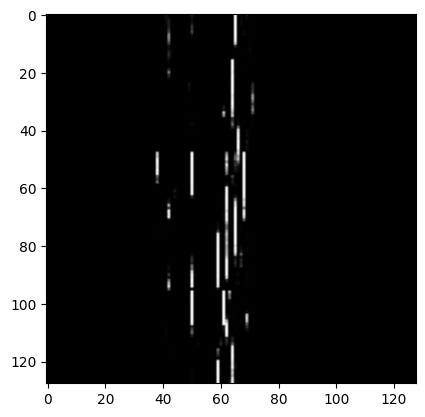

In [5]:
plt.imshow(generated_image[0], cmap='gray')
plt.show()

In [6]:
for matrix in generated_image:
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] < 0.99:
                matrix[i][j] = 0

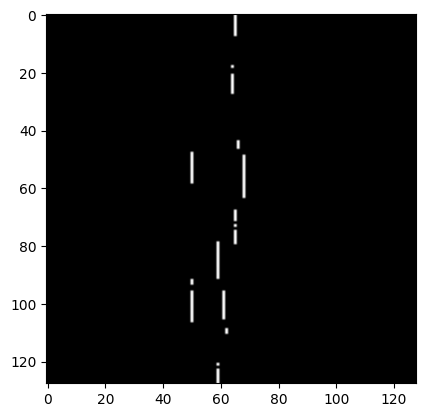

In [7]:
plt.imshow(generated_image[0], cmap='gray')
plt.show()

In [8]:
np.save('generated/piano_rolls/classical/piano_rolls.npy', generated_image.reshape(-1, 128, 128))